# Computational Statistics Assignment
## Preparation
### Importing the packages and data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
mydata = pd.read_csv('a1_data.csv')
mydata.head()

,A,B,C,D,E,F,G,H,I,J,K
0,3.179665,3.030625,3.222752,2.836624,3.386284,1.910165,2.179628,3.464657,3.705143,3.921797,3.566766
1,3.313155,3.127535,3.367189,2.799483,2.527001,2.359419,2.461049,3.394200,3.002324,3.487035,3.753581
2,3.531847,3.554489,3.441636,2.582776,2.730851,2.263097,2.461049,3.452962,3.531599,3.773342,3.254741
3,3.621384,3.828081,3.640896,2.704508,1.727649,1.855651,2.021082,3.570291,3.611415,3.725917,3.328318
4,3.285691,3.206716,2.992451,2.562289,3.011359,2.414187,2.612864,3.331957,3.143080,3.679484,3.874796


### A little EDA (Exploration Data Analysis)

C:\Users\hiwzr\AppData\Local\Temp\ipykernel_71176\746115273.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(df, dtype=np.bool)


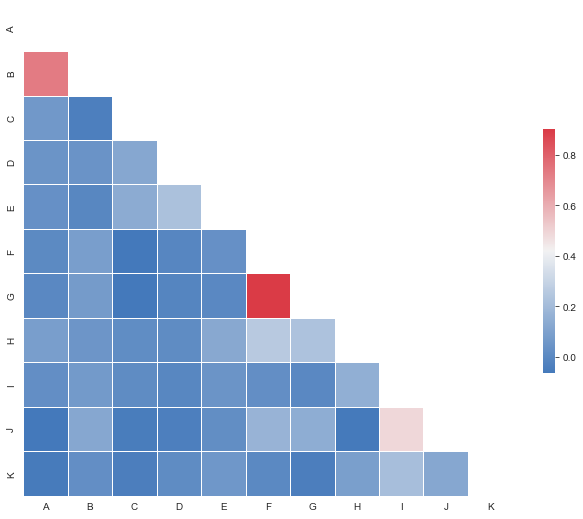

In [3]:
import seaborn as sns
def CorrMtx(df, dropDuplicates = True):

    # Your dataset is already a correlation matrix.
    # If you have a dateset where you need to include the calculation
    # of a correlation matrix, just uncomment the line below:
    # df = df.corr()

    # Exclude duplicate correlations by masking uper right values
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

    # Set background color / chart style
    sns.set_style(style = 'white')

    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Add diverging colormap from red to blue
    cmap = sns.diverging_palette(250, 10, as_cmap=True)

    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        sns.heatmap(df, mask=mask, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
    else:
        sns.heatmap(df, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)


CorrMtx(mydata.corr(), dropDuplicates = True)

From the correlation plot, we can oberve that only A & B, F & G, and I & J are highly correlated. We assume there are strong causal relations between them. But of course, causal inference 101: correlation does not imply causation!

## Drawing DAG
### Undirected Edges Between Nodes

In [4]:
from scipy.stats import linregress

## for all the possible pairs in 11 variables, which of them are connected in DAG?
### t-test for existence of edges###
variables = list(mydata.columns)
variable_len = len(variables)

## Loop for every pair of variables
k = 0
m = 0
p_values = pd.DataFrame({'var1': [], 'var2' : [], 'p_ifedge' :[]})

for i in variables:
  k += 1
  for n in range(k,variable_len):
    
    ### SELECT THE VARIABLES
    var1 = i
    var2 = variables[n]
    #df = mydata[,c(var1,var2)]
    #colnames(df) = c("val1", "val2")
    
    ### t test: beta =0 agaist beta =! 0
    p =linregress(mydata[var1], mydata[var2]).pvalue

    
    ### add row to the df for p values
    newrow = pd.DataFrame({'var1': var1, 'var2' : var2, 'p_ifedge' :p}, index=[m])
    p_values = pd.concat([p_values, newrow], ignore_index=True)
    m+=1

p_values.head()
  



,var1,var2,p_ifedge
0,A,B,0.000000e+00
1,A,C,1.045810e-10
2,A,D,4.141430e-07
3,A,E,8.747962e-04
4,A,F,5.231871e-01


In [5]:
# draw edges for p values smaller than a threshold
threshold = 0.01 ##### Change this maybe?
edge_df = p_values[p_values["p_ifedge"]<threshold]
edge_df.shape

(39, 3)

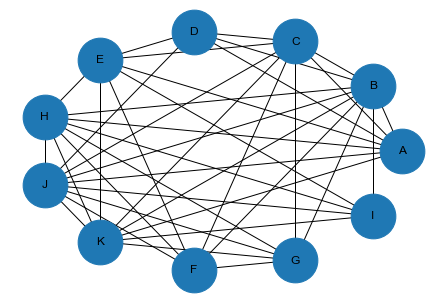

In [6]:
import networkx as nx

# create an undirected graph from the dataframe
Undirected = nx.from_pandas_edgelist(edge_df, 'var1', 'var2', create_using=nx.Graph())

# visualize the graph
pos = nx.circular_layout(Undirected)  # layout for visualization
nx.draw(Undirected, pos, with_labels=True,  node_size= 2000)
plt.show()

### Direction of Edges (Causal Orientation)

In [7]:
## for all edges, what is the direction? (causal orientation)
# F-TEST
from scipy.stats import f


pf = []

for i, row in edge_df.iterrows():
    var1 = row['var1']
    var2 = row['var2']

    ratio = np.var(mydata[var1])/np.var(mydata[var2])
    df1 = len(mydata[var1])-1
    df2 = len(mydata[var2])-1

    p = f.sf(ratio, df1, df2)
    pf.append(p)

edge_df = edge_df.assign(p_direction=pf)
edge_df.head()

,var1,var2,p_ifedge,p_direction
0,A,B,0.000000e+00,2.287356e-13
1,A,C,1.045810e-10,9.999993e-01
2,A,D,4.141430e-07,1.000000e+00
3,A,E,8.747962e-04,1.000000e+00
6,A,H,1.374396e-19,8.040344e-01


In [8]:
# finding the direction
threshold2 = .05
edge_df["direction"] = ['->' if value > threshold2 else '<-' for value in edge_df['p_direction']]

edge_df.head()

,var1,var2,p_ifedge,p_direction,direction
0,A,B,0.000000e+00,2.287356e-13,<-
1,A,C,1.045810e-10,9.999993e-01,->
2,A,D,4.141430e-07,1.000000e+00,->
3,A,E,8.747962e-04,1.000000e+00,->
6,A,H,1.374396e-19,8.040344e-01,->


### Drawing the final DAG

In [9]:
# Edge list
source = []
sink = []

for i, row in edge_df.iterrows():
    if row['direction'] == "->":
        source.append(row['var1'])
        sink.append(row['var2'])
    else:
        source.append(row['var2'])
        sink.append(row['var1'])

edgelist_df = pd.DataFrame({'source':source,'sink':sink})
edgelist_df.head()


,source,sink
0,B,A
1,A,C
2,A,D
3,A,E
4,A,H


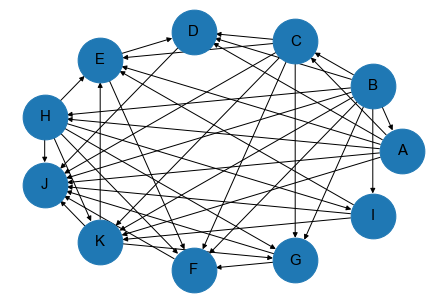

In [18]:
# create an undirected graph from the dataframe
directed = nx.from_pandas_edgelist(edgelist_df, 'sink','source', create_using=nx.DiGraph())
directed = nx.DiGraph.reverse(directed)

# visualize the graph
pos = nx.circular_layout(directed)  # layout for visualization
nx.draw(directed, pos, with_labels=True, arrows=True, font_size=15, node_size= 2000)
plt.show()

## Validation
### Checking the direction of edges

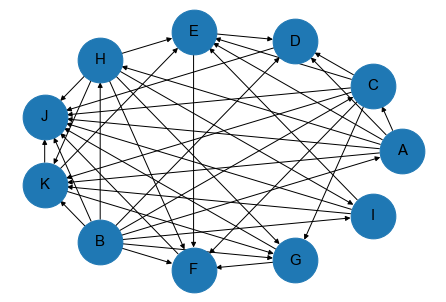

In [26]:
from cdt.causality.pairwise import ANM

obj = ANM()

directed_val = obj.orient_graph(mydata, nx.DiGraph(directed))

pos = nx.circular_layout(directed_val)  # layout for visualization
nx.draw(directed_val,pos, with_labels=True, font_size=15, node_size= 2000)

<img src="pc_result.png" alt="caption" width="500" >